In [ ]:
### decodingCallTypes 3 uses the information from part2
## Copy of decodingCallTypesNaiveBayespart3Julie-PerBird and modified to do the per region

In [1]:
# Dependencies 
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pk
import multiprocessing as mp
from scipy.stats import t
from sklearn.naive_bayes import GaussianNB
from scipy.special import comb
from scipy.stats import norm
import itertools

from decoders import naiveBayes

import config

In [2]:
# Some paths
rootPath = '/Users/frederictheunissen/Google Drive/My Drive/julie/'
# rootPath = '/Users/frederictheunissen/Google Drive/julie/'
pklPath = 'pkl/'


# The 6 birds from Julie data set
birds = ['BlaBro09xxF', 'GreBlu9508M', 'WhiBlu5396M', 'LblBlu2028M', 'WhiWhi4522M', 'YelBlu6903F']

# Color code for call type
callColor = {'Be': (0/255.0, 230/255.0, 255/255.0), 'LT': (0/255.0, 95/255.0, 255/255.0), 'Tu': (255/255.0, 200/255.0, 65/255.0), 'Th': (255/255.0, 150/255.0, 40/255.0), 
             'Di': (255/255.0, 105/255.0, 15/255.0), 'Ag': (255/255.0, 0/255.0, 0/255.0), 'Wh': (255/255.0, 180/255.0, 255/255.0), 'Ne': (255/255.0, 100/255.0, 255/255.0),
             'Te': (140/255.0, 100/255.0, 185/255.0), 'DC': (100/255.0, 50/255.0, 200/255.0), 'So': (255/255.0, 255/255.0, 255/255.0)}



In [3]:
# Load the data base
outPath = rootPath+'JulieDataBase.pkl'
fileIn = open(outPath,"rb")
dfDataBase = pk.load(fileIn)
pcKDE = pk.load(fileIn)
fileIn.close()

In [4]:
dfDataBaseNW = dfDataBase[dfDataBase['call'] != 'Wh']
# Number of Calls
callNames = np.unique(dfDataBaseNW['call'])
ncalls = callNames.shape[0]

In [5]:
# read unitList and argList2 and Confusion matrices data base
inPath = rootPath+ pklPath + 'JulieDataBaseGoodUnitList.pkl' 
fileIn = open(inPath,"rb")
argList2 = pk.load(fileIn)
unitList = list(pk.load(fileIn))

fileIn.close()

In [6]:
# read unitList and argList10 and Confusion matrices data base
inPath = rootPath+ pklPath + 'JulieDataBaseGoodUnitList10.pkl' 
fileIn = open(inPath,"rb")
argList10 = pk.load(fileIn)
unitList10 = list(pk.load(fileIn))

fileIn.close()

In [7]:
print(len(unitList))
print(len(unitList10))

408
375


In [8]:
siteList = pd.read_csv(rootPath+'h5_listFiles_CallProtocol.txt', sep='\s+', header=None, names = ['CellNumber', 'Path'])

birdL = []
siteL = []

for path in siteList['Path']:
    pathSplit = path.split("/")
    bird = pathSplit[5]
    site = (pathSplit[6].split('.')[0])[0:-3]
    birdL.append(bird)
    siteL.append(site)

In [9]:
# Printing the name of the most discriminating units
birdName = []
for unit in unitList10:
    ind = siteL.index(unit[0:-7])
    birdName.append(birdL[ind])
    
birdUnique = np.unique(birdName)
for bird in birdUnique:
    print(bird, ":", len([x for x in birdName if x == bird]))

BlaBro09xxF : 21
GreBlu9508M : 171
WhiWhi4522M : 83
YelBlu6903F : 100


In [10]:
# Read the histology files for these 4 birds
for i, bird in enumerate(birdUnique):
    histListBird = pd.read_csv(rootPath+'histology/List_h5files_' + bird + '_Histo.txt', 
                           sep='\t', header=None, index_col = False,
                           names = ['h5file', 'Region', 'dlat', 'dL2A', 'Hemisphere', 'headstage'])
    
    if (i == 0 ):
        histList = histListBird
    else:
        histList = pd.concat([histList, histListBird], ignore_index = True)

In [11]:
regionName = []
zoneName = []
for i, unit in enumerate(unitList10):
    region = histList.loc[histList['h5file'] == unit[0:-4]+'.h5']['Region']
    if len(region):
        reg = region.array[0]
    else:
        reg = 'NA'
    regionName.append(reg)
    if (('CMM' in reg) | ('NCM' in reg) & ~('L' in reg)):
        zoneName.append('NCM-CMM')
    elif ( reg == 'NA'):
        zoneName.append('NA')
    else:
        zoneName.append('L')

In [12]:
zoneUnique = np.unique(zoneName)

In [13]:
zoneUnique

array(['L', 'NCM-CMM'], dtype='<U7')

In [14]:
for izone, zone in enumerate(zoneUnique):
    nGoodZone = len([x for x in zoneName if x == zone])
    print(zone, ':', nGoodZone, 'units')

L : 166 units
NCM-CMM : 209 units


In [15]:
# Generates the common stimulus set
def commonStim(siteUnit, unitList):
      
    for i, unit in enumerate(unitList):
        tempStims = np.unique(dfDataBaseNW['stim'][siteUnit==unit].values)
        if i == 0 :
            stimSet = set(tempStims)
        stimSet = stimSet.intersection(tempStims)
                               
    return stimSet
        

In [ ]:
# We are doing 1,2,3,4,5,10,20
numUnits = 2

#nGood = len(unitList)
nGood = len(unitList10)

maxTest = 2000  # This is 2000 for subgroups and 800 for 20
nZones = len(zoneUnique)
argListZones = [[] for i in range(nZones)]
ntests = np.zeros((nZones,), dtype=int)

siteUnit = (dfDataBaseNW['site']+'_'+dfDataBaseNW['unit'])
#nGoodPairs = len(argList2)
nGoodPairs = len(argList10)

# For more than 3 units look for previous combinations that worked
if numUnits > 3 :
    foundFile = False
    testUnits = numUnits - 1
    while not foundFile: 
        pathIn = rootPath + pklPath + 'JulieDataBase%dGoodUnitPCPerZone.pkl' % testUnits
        if os.path.exists(pathIn) :
            foundFile = True
            fileIn = open(pathIn, 'rb')
            argListZonesPrev = pk.load(fileIn)
            fileIn.close()
            print('Found file from previous run')
        else:
            testUnits -= 1
            

for izone, zone in enumerate(zoneUnique):
    nGoodZone = len([x for x in zoneName if x == zone])
    print(zone, ':', nGoodZone, 'units')
    if nGoodZone < numUnits:
        continue
        
    xtests = comb(nGoodZone,numUnits)
    if xtests > maxTest:
        ntests[izone] = maxTest + 1
    else:
        ntests[izone] = int(xtests)

    # Generate the good index for this bird
    indGoodZone = [ind for ind, zonelist in enumerate(zoneName) if zonelist == zone]
    unitListZone = [unitList10[i] for i  in indGoodZone]

    # Generate the list of arguments to run naiveBayes in parallel
    argList = argListZones[izone]
    if (numUnits == 1):
        for i, unit in enumerate(unitListZone):
            if i == ntests[izone]:
                break
            unitChoice = [unit]
            argList.append(unitChoice)
    elif (numUnits == 2):
        i = 0
        for i1, unit1 in enumerate(unitListZone):
            for i2, unit2 in enumerate(unitListZone):
                if i2 <= i1:
                    continue
                unitChoice = [unit1, unit2]
                stimSet = commonStim(siteUnit, unitChoice)
                if len(stimSet) > 100 :
                    argList.append(unitChoice)
                    i += 1
                    if (i%100 == 0 ):
                        print(i, '...')
                if (i == ntests[izone]):
                    break
            if (i == ntests[izone]):
                break
          
    elif (numUnits == 3 and ntests[izone] <= maxTest):      
        # Generate all possible combinations
        for unitChoice in itertools.combinations(unitListZone, numUnits):
            stimSet = commonStim(siteUnit, unitChoice)
            if len(stimSet) > 100 :
                argList.append(list(unitChoice))
    else:
        i = 0
        while i < ntests[izone]:
            
            if (numUnits == 3 or not foundFile ):
                # Choose 1rst one randomly to get going
                unitChoice = [unitListZone[np.random.randint(nGoodZone)]]
            else:
                # Choose the first few from previous run            
                unitChoice = argListZonesPrev[izone][np.random.randint(len(argListZonesPrev[izone]))]
                if (i==0):
                    print('Starting choice:', unitChoice)
    
            # choose additional ones, one by one:
            unitListTest = unitListZone.copy()
            while (len(unitChoice) < numUnits) & (len(unitListTest) > 0) :
                newUnit = np.random.choice(unitListTest, 1, replace=False)
                if newUnit in unitChoice:
                    unitListTest.remove(newUnit)
                    continue

                unitChoiceTemp = unitChoice.copy()
                unitChoiceTemp.append(newUnit[0])
        
                stimSet = commonStim(siteUnit, unitChoiceTemp)
                if len(stimSet) > 100 :
                    unitChoice.append(newUnit[0])
                else:
                    unitListTest.remove(newUnit)
    
            if (len(unitChoice) == numUnits) & (unitChoice not in argList):
                argList.append(unitChoice)
                i += 1
                if (i%100 == 0 ):
                    print(i, '...')



In [32]:
# One can start here insttead of running the previous cell and read a previously ran set
# We are doing 1,2,3,4,5,10,20
numUnits = 20

# read the PC and Confusion matrices data base
inPath = rootPath + pklPath + 'JulieDataBase%dGoodUnitPCPerZone.pkl' % numUnits
fileIn = open(inPath,"rb")
argListZones = pk.load(fileIn)
fileIn.close()

nZones = len(zoneUnique)
ntests = np.zeros((nZones,), dtype=int)

for izone, zone in enumerate(zoneUnique):
    ntests[izone] =  len(argListZones[izone])

In [33]:
print('For ensemble size of', numUnits)
for izone, zone in enumerate(zoneUnique):
    print(zone, ':', len(argListZones[izone]), 'combinations to be tested')

For ensemble size of 20
L : 801 combinations to be tested
NCM-CMM : 801 combinations to be tested


In [34]:
# Run the decoders using multiprocessors if possible
mpflag = True

# Run Naive Bayes in chunks of 90 with a pool of 30 workers
chunckSize = 100    # A chunk size of 100 is used for memory since it has to keep the results of all or 90 and 1800 tests.
poolSize = 30       # 10 for laptop, 30 for desktop

# Allocate memory for results
pccZones = []
selHZones = []
confMatTotZones = []



for izone, zone in enumerate(zoneUnique):
    
    # Allocate bird specific storage for the results
    pcc = np.zeros((ntests[izone],))
    selH = np.zeros((ntests[izone],))
    confMatTot = np.zeros((ncalls, ncalls))
    confMatCount = 0
    
    # Calculate the number of chunks
    nchunks = ntests[izone]//chunckSize
    if ntests[izone] % chunckSize:
        nchunks += 1
        
    # Arglist for this zone
    argList = argListZones[izone]
    
    
    if mpflag == True:
        if __name__ == '__main__':
            for ichunk in range(nchunks):
                istart = ichunk*chunckSize
                iend = (ichunk+1)*chunckSize
                if iend > ntests[izone]:
                    iend = ntests[izone]         
        
                with mp.Pool(poolSize) as p:
                    results = p.map(naiveBayes, argList[istart:iend])
        
            # I don't think I need these??
            # p.close()
            # p.join()
        
                for i, res in enumerate(results):
                    confMat = res[1]
                    if (confMat.shape == (ncalls,ncalls) ):
                        pcc[istart + i] = res[0]
                        pccDiag = np.diag(confMat)
                        pccDiag = pccDiag/np.sum(pccDiag)
                        pccDiag[pccDiag == 0] = 1. # Because 0log0 = 0
                        selH[istart + i] = 1 - np.sum(-pccDiag*np.log2(pccDiag))/(np.log2(ncalls))
                        testsPerClass = res[2]
                        confMatTot = np.add(confMatTot, confMat)
                        confMatCount += testsPerClass
                
                print('Done with chunk %d/%d for zone %d/%d' % (ichunk+1, nchunks, izone+1, nZones))
    else:
        for i in range(ntests[izone]):
            pccval, confMat, testsPerClass = naiveBayes(argList[i], code = code)
            pcc[i] = pccval
            pccDiag = np.diag(confMat)
            pccDiag = pccDiag/np.sum(pccDiag)
            pccDiag[pccDiag == 0] = 1. # Because 0log0 = 0
            selH[i] = 1 - np.sum(-pccDiag*np.log2(pccDiag))/(np.log2(ncalls))
            confMatTot = np.add(confMatTot, confMat)
            confMatCount += testsPerClass

    # Calculate the average confusion matrix. 
    for i in range(ncalls):
        if confMatCount[i] > 0:
            confMatTot[i,:] = confMatTot[i,:]/confMatCount[i]
            
    # Store the results in the bird lists
    pccZones.append(pcc)
    selHZones.append(selH)
    confMatTotZones.append(confMatTot)
    
        
# save the PC and Confusion matrices data base
outPath = rootPath + pklPath + 'JulieDataBase%dGoodUnitPCPerZone.pkl' % numUnits
fileOut = open(outPath,"wb")
pk.dump(argListZones, fileOut)
pk.dump(confMatTotZones, fileOut)
pk.dump(pccZones, fileOut)
pk.dump(selHZones, fileOut)
pk.dump(zoneUnique, fileOut)
fileOut.close()



Done with chunk 1/9 for zone 1/2
Done with chunk 2/9 for zone 1/2
Done with chunk 3/9 for zone 1/2
Done with chunk 4/9 for zone 1/2
Done with chunk 5/9 for zone 1/2
Done with chunk 6/9 for zone 1/2
Done with chunk 7/9 for zone 1/2
Done with chunk 8/9 for zone 1/2
Done with chunk 9/9 for zone 1/2
Done with chunk 1/9 for zone 2/2
Done with chunk 2/9 for zone 2/2
Done with chunk 3/9 for zone 2/2
Done with chunk 4/9 for zone 2/2
Done with chunk 5/9 for zone 2/2
Done with chunk 6/9 for zone 2/2
Done with chunk 7/9 for zone 2/2
Done with chunk 8/9 for zone 2/2
Done with chunk 9/9 for zone 2/2


In [1]:
for izone in range(nZones):
    print(np.mean(pccZones[izone]))

NameError: name 'nZones' is not defined

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


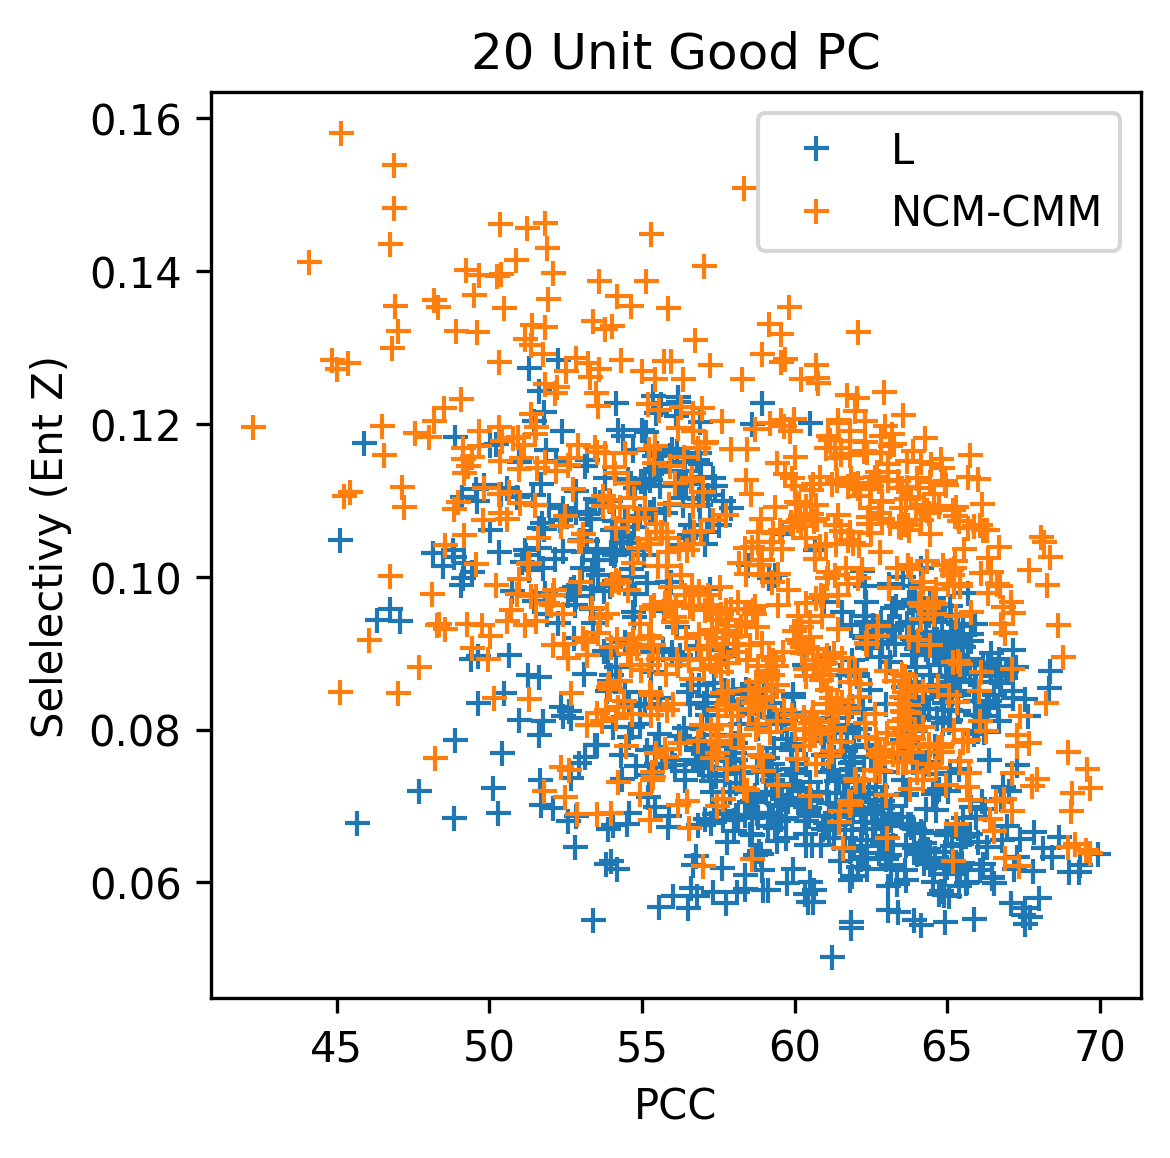

In [36]:
fig = plt.figure(figsize=(4,4), dpi=300)
ax = fig.subplots()

for izone, zone in enumerate(zoneUnique):
    ax.plot(pccZones[izone], selHZones[izone], '+', label = zone)

ax.set_xlabel('PCC')
ax.set_ylabel('Selelectivy (Ent Z)')
ax.set_title('%d Unit Good PC' % numUnits)
ax.legend()

plt.savefig('/Users/frederictheunissen/Desktop/scatterPCCSelJ%dUnitGoodPCPerZone.eps' % numUnits)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


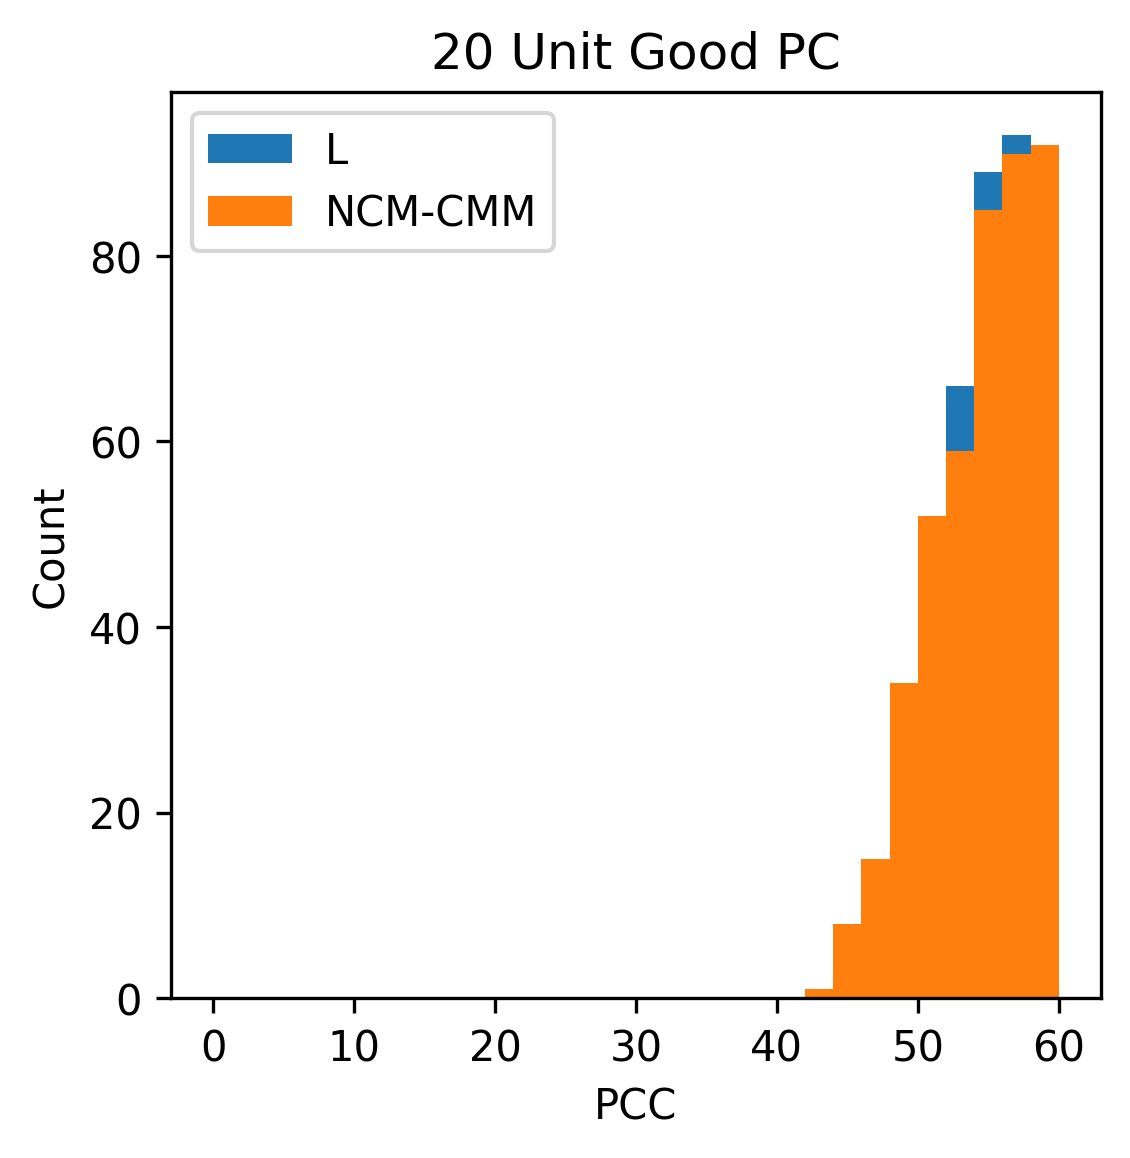

In [37]:
fig = plt.figure(figsize=(4,4), dpi=300)
ax = fig.subplots()

for izone, zone in enumerate(zoneUnique):
   ax.hist(pccZones[izone], bins = 30, range = (0,60), label=zone)

ax.set_xlabel('PCC')
ax.set_ylabel('Count')
ax.set_title('%d Unit Good PC' % numUnits)
ax.legend()

plt.savefig('/Users/frederictheunissen/Desktop/pcchistJ%dUnitGoodPCPerZone.eps' % numUnits)

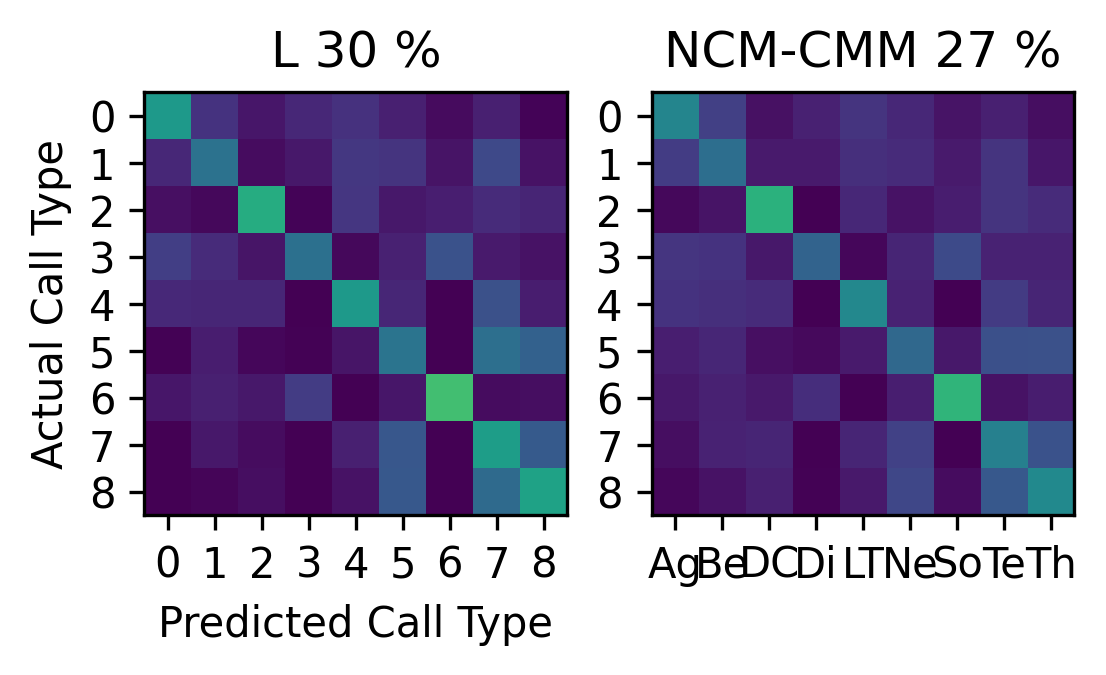

In [29]:
# Plot the overall confusion matrix

cmap='viridis'
fig = plt.figure(figsize=(4,12), dpi=300)
axZones = fig.subplots(1, nZones)

for izone, zone in enumerate(zoneUnique):
    ax = axZones[izone]
    im_ = ax.imshow(confMatTotZones[izone]*100.0, interpolation='nearest', cmap=cmap, 
                    extent = (-0.5, ncalls-0.5, ncalls-0.5, -0.5), vmin=5, vmax = 50)

    
    if izone == 0 :
        ax.set(xticks=np.arange(ncalls),
               yticks=np.arange(ncalls),
               ylim = (ncalls-0.5, -0.5),
               # xticklabels=callNames,
               # yticklabels=callNames,
               ylabel="Actual Call Type",
               xlabel="Predicted Call Type",
               title='%s %.0f %%' % (zone, np.mean(pccZones[izone])))
    else:
        ax.set(xticks=np.arange(ncalls),
               yticks=np.arange(ncalls),
               ylim = (ncalls-0.5, -0.5),
               xticklabels=callNames,
               # yticklabels=callNames,
               # ylabel="Actual Call Type",
               # xlabel="Predicted Call Type",
               title='%s %.0f %%' % (zone, np.mean(pccZones[izone])))
        

plt.savefig('/Users/frederictheunissen/Desktop/confMatJ%dUnitGoodPCPerZone.eps' % numUnits)

